## 1 Data Preprocessing

In [3]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from time import sleep
import math

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# target information (IMPORTANT!)
target_symbol = 'XAUUSD'
target_timeframe = 'M15'
optional_plot = False
send_order = True

interval_tf1 = { 'M5': Interval.in_5_minute,
                 'M15': Interval.in_15_minute,
                 'H1': Interval.in_1_hour,
                 'H4': Interval.in_4_hour,
                 'D1': Interval.in_daily }

interval_tf2 = { 'M5': Interval.in_1_minute,
                 'M15': Interval.in_5_minute,
                 'H1': Interval.in_15_minute,
                 'H4': Interval.in_1_hour,
                 'D1': Interval.in_4_hour }

time_unit = { 'M5': 'Minute',
              'M15': 'Hour',
              'H1': 'Hour',
              'H4': 'Hour',
              'D1': 'Day' }


# Fetch historical data for the target symbol
forex_data = tv.get_hist(symbol=target_symbol, exchange='ICMARKETS',
                              interval=interval_tf1[target_timeframe], n_bars=4000)

sleep(1)

# Fetch lower timeframe data for TFO
forex_data_lowertf = tv.get_hist(symbol=target_symbol, exchange='ICMARKETS',
                              interval=interval_tf2[target_timeframe], n_bars=1000)

prices = forex_data['close']
print(prices)

# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

you are using nologin method, data you access may be limited


datetime
2024-09-30 12:17:00    2654.94
2024-09-30 12:32:00    2654.52
2024-09-30 12:47:00    2655.81
2024-09-30 13:02:00    2655.03
2024-09-30 13:17:00    2656.60
                        ...   
2024-11-30 02:32:00    2651.90
2024-11-30 02:47:00    2652.50
2024-11-30 03:02:00    2650.55
2024-11-30 03:17:00    2649.52
2024-11-30 03:32:00    2650.39
Name: close, Length: 4000, dtype: float64


In [4]:
forex_data_lowertf['close'][-20:]

datetime
2024-11-30 02:07:00    2659.02
2024-11-30 02:12:00    2659.32
2024-11-30 02:17:00    2658.24
2024-11-30 02:22:00    2659.38
2024-11-30 02:27:00    2653.84
2024-11-30 02:32:00    2652.88
2024-11-30 02:37:00    2652.42
2024-11-30 02:42:00    2651.90
2024-11-30 02:47:00    2653.11
2024-11-30 02:52:00    2652.74
2024-11-30 02:57:00    2652.50
2024-11-30 03:02:00    2652.60
2024-11-30 03:07:00    2650.72
2024-11-30 03:12:00    2650.55
2024-11-30 03:17:00    2650.02
2024-11-30 03:22:00    2649.62
2024-11-30 03:27:00    2649.52
2024-11-30 03:32:00    2649.14
2024-11-30 03:37:00    2649.30
2024-11-30 03:42:00    2650.39
Name: close, dtype: float64

In [5]:
# Apply Savitzky-Golay filter to get the trend
# Note that in scipy Savitzky-Golay filter, the last elements are calculated by padding,
# so we would remove them to ensure an accurate trend data

yvalues_trend = []
yvalues_seasonal = []

yvalues = prices[:]
yvalues_trend.append(savgol_filter(yvalues,19,1))
yvalues_trend.append(savgol_filter(yvalues_trend[0],59,1))
yvalues_trend.append(savgol_filter(yvalues_trend[1],179,1))
yvalues_seasonal.append(yvalues-yvalues_trend[0])
yvalues_seasonal.append(yvalues_trend[0]-yvalues_trend[1])
yvalues_seasonal.append(yvalues_trend[1]-yvalues_trend[2])

yvalues_trend_forecast    = [None] * 3
yvalues_seasonal_forecast = [None] * 3
results_trend             = [None] * 3
results_seasonal          = [None] * 3

In [6]:
# Optional: Plot the decomposed time series
if (optional_plot):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(np.arange(-800,0), yvalues[-800:], label='Original input',linewidth=3)
    ax.plot(np.arange(-800,0), yvalues_trend[0][-800:], label='Trend Component')
    ax.plot(np.arange(-800,0), yvalues_trend[1][-800:], label='Meta Trend Component')
    ax.plot(np.arange(-800,0), yvalues_trend[2][-800:], label='Macro Trend Component')
    ax.legend()
    ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
    plt.tight_layout()
    plt.show()

## 2 Definition of Parameters and Functions

Trends can have different scales, each needing tailored forecasting tools:
- Large Scale (Red): Simple linear models suffice.
- Medium Scale (Green): Polynomial fitting works well.
- Small Scale (Orange): Clear cyclic patterns best handled by FFT.

For practical, short-term applications, the medium scale is often sufficient, minimizing major forecast deviations. 

In the past, we attempted to use ARIMA models to predict the orange trend. However, due to its inherent cyclic nature, ARIMA did not provide accurate results. Then we shifted to using FFT directly on the orange trend, but since FFT should be applied after detrending, the forecasts deviated substantially.

Now we will do the forecast like this:
- Medium scale trend: Polynomial fitting
- Medium scale seasonal / Small scale trend: FFT
- Small scale seasonal: FFT

Validation is need for both Polynomial fitting and FFT.

In [8]:
# Definition of Forecast Parameters
forecast_elements = 40

t1_validation_elements_list = np.arange(16, 81, 8)
t1_input_elements_list      = np.arange(12, 33, 4)

s1_validation_elements_list = np.arange(16, 25, 4)
s1_harmonics_list           = np.arange(10, 61, 10)
s1_input_elements_list      = np.arange(400, 1601, 10)

s0_validation_elements_list = [8]
s0_harmonics_list           = np.arange(20, 60, 10)
s0_input_elements_list      = np.arange(200, 800, 4)

In [9]:
def poly_forecast(signal, forecast_elements, fit_window=None, degree=2):
    """
    Extend a time series using polynomial fitting on a portion of the end of the series.

    Parameters:
    - signal: numpy array of original time series data.
    - forecast_elements: int, number of future points to extend.
    - degree: int, degree of the polynomial to fit.
    - fit_window: int or None, number of data points from the end of the series to use for fitting.
                  If None, use the entire series.

    Returns:
    - extended_time_series: numpy array of the original and extended time series.
    """
    # Determine the portion of the time series to use for fitting
    if fit_window is None or fit_window > len(signal):
        fit_window = len(signal)
    
    # Select the last `fit_window` points for fitting
    time_points = np.arange(len(signal) - fit_window, len(signal))
    fit_series = signal[-fit_window:]
    
    # Fit a polynomial of the specified degree to the selected portion of the series
    coefficients = np.polyfit(time_points, fit_series, degree)
    poly_func = np.poly1d(coefficients)
    
    # Create extended time points
    extended_time_points = np.arange(len(signal), len(signal) + forecast_elements)
    
    # Use the polynomial to predict extended values
    extended_values = poly_func(extended_time_points)
    
    # Combine the original series with the extended values
    extended_time_series = np.concatenate((signal, extended_values))
    
    return extended_time_series

In [10]:
def fft_forecast(signal, forecast_elements, fit_window=None, target_harmonics=40, trend_factor=0, trend_strength=0):
    # Store the full length of the original signal
    original_length = len(signal)
    
    # Use only the last `window` elements if specified for FFT, otherwise use the entire signal
    if fit_window is not None and fit_window < original_length:
        signal_fft = signal[-fit_window:]
    else:
        signal_fft = signal
    
    # Extend the FFT portion of the signal with a linear trend if specified
    if trend_strength > 0:
        trend_extension = signal_fft[-1] + trend_factor * np.arange(1, trend_strength + 1)
        extended_signal = np.concatenate((signal_fft, trend_extension))
    else:
        extended_signal = signal_fft
    
    N = len(extended_signal)
    
    # Perform FFT on the extended signal
    fft_result = np.fft.fft(extended_signal)
    fft_freq = np.fft.fftfreq(N)
    
    # Retain non-negative frequencies
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]
    
    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]
    
    # Create extended indices including future points
    extended_indices = np.arange(N + forecast_elements)
    
    # Reconstruct the signal using the selected harmonics
    reconstructed_signal = np.zeros(N + forecast_elements)
    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency
        
        if frequency == 0:
            # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    # Define the length of the blend window as half of the original signal length
    blend_window = original_length // 2 if fit_window is None else fit_window // 2
    
    # Initialize the blended signal with the correct length
    blended_signal = np.zeros(original_length + forecast_elements)
    
    # Copy the original signal into the beginning of blended_signal
    blended_signal[:original_length - blend_window] = signal[:original_length - blend_window]
    
    # Blend the end of the original signal with the reconstructed signal
    for i in range(0, blend_window):  # Iterate through the last `blend_window` elements of the original signal
        idx = original_length - blend_window + i
        alpha = i / blend_window  # Adjusted alpha calculation to range from 0 to 1
        blended_signal[idx] = (1 - alpha) * signal[idx] + alpha * reconstructed_signal[blend_window+i]
    
    # Append the forecasted portion from the reconstructed signal
    blended_signal[original_length:] = reconstructed_signal[fit_window:fit_window+forecast_elements]
    
    return blended_signal


In [11]:
def poly_forecast_validation(signal, forecast_elements, validation_elements_list, input_elements_list, degree=2):
    
    results = []

    for validation_elements in validation_elements_list:
        for input_elements in input_elements_list:
            
            signal_forecast = poly_forecast(signal[:-validation_elements], validation_elements+forecast_elements, input_elements, degree)

            # Convert forecasts to numpy arrays if they are pandas Series
            if isinstance(signal_forecast, pd.Series):
                signal_forecast = signal_forecast.to_numpy()
            if isinstance(signal, pd.Series):
                signal = signal.to_numpy()
            
            # Extract validation portions
            actual_validation = signal[-validation_elements:]
            forecast_validation = signal_forecast[-validation_elements - forecast_elements:-forecast_elements]

            # Calculate distances
            dtw_value = dtw.distance(actual_validation, forecast_validation)
            rmse_value = np.sqrt(mean_squared_error(actual_validation, forecast_validation))

            # Store the results
            results.append({
                'poly_validation_elements': validation_elements,
                'poly_input_elements': input_elements,
                'rmse_validation': rmse_value,
                'dtw_validation': dtw_value
            })

    # Convert results to DataFrame and sort
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by='rmse_validation', ascending=True).head(20)
    return df_results


In [12]:
def fft_forecast_validation(signal, forecast_elements, validation_elements_list, input_elements_list, harmonics_list):

    results = []

    # Ensure signal is a numpy array
    if isinstance(signal, pd.Series):
        signal = signal.to_numpy()

    # Iterate over all combinations of validation_elements, input_elements, and harmonics
    for validation_elements in validation_elements_list:
        for input_elements in input_elements_list:
            for harmonics in harmonics_list:
                
                # Define the total number of elements to forecast (validation + forecast)
                total_forecast_length = validation_elements + forecast_elements

                # Prepare the training signal by excluding the last 'validation_elements' points
                training_signal = signal[:-validation_elements]

                # Perform FFT-based forecasting
                try:
                    signal_forecast = fft_forecast(
                        signal=training_signal,
                        forecast_elements=total_forecast_length,
                        fit_window=input_elements,
                        target_harmonics=harmonics,
                        trend_factor=0,        # Set to 0 or adjust as needed
                        trend_strength=0       # Set to 0 or adjust as needed
                    )
                except ValueError as e:
                    print(f"ValueError for validation_elements={validation_elements}, "
                          f"input_elements={input_elements}, harmonics={harmonics}: {e}")
                    continue  # Skip this combination if an error occurs

                # Extract validation portions
                actual_validation = signal[-validation_elements:]
                forecast_validation = signal_forecast[-validation_elements - forecast_elements:-forecast_elements]

                # Calculate RMSE and DTW distance
                rmse_value = np.sqrt(mean_squared_error(actual_validation, forecast_validation))
                dtw_value = dtw.distance(actual_validation, forecast_validation)

                # Store the results
                results.append({
                    'fft_validation_elements': validation_elements,
                    'fft_input_elements': input_elements,
                    'fft_harmonics': harmonics,
                    'rmse_validation': rmse_value,
                    'dtw_validation': dtw_value
                })

    # Convert the results list to a pandas DataFrame
    df_results = pd.DataFrame(results)

    # Sort the DataFrame by RMSE in ascending order and select the top 20 results
    df_results = df_results.sort_values(by='rmse_validation', ascending=True).head(40)
    df_results = df_results.sort_values(by='dtw_validation', ascending=True).head(20)

    return df_results


In [13]:
def find_optimal_clusters(data, max_clusters=4):
    """Find optimal number of clusters using silhouette score."""
    # data is expected to be a 2D array of shape (n_samples, n_timepoints)
    n_samples = data.shape[0]
    data_reshaped = data.reshape(n_samples, -1)  # Ensure data is 2D
    
    # Try different numbers of clusters
    silhouette_scores = []
    for k in range(2, min(max_clusters + 1, n_samples)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_reshaped)
        score = silhouette_score(data_reshaped, cluster_labels)
        silhouette_scores.append(score)
    
    # Return optimal number of clusters
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_k

## 3.1 Medium Trend Forecast

In [15]:
results_trend[1] = poly_forecast_validation(yvalues_trend[1], forecast_elements, t1_validation_elements_list, t1_input_elements_list, degree=2)
results_trend[1]

,poly_validation_elements,poly_input_elements,rmse_validation,dtw_validation
0,16,12,4.299107e-12,1.719643e-11
1,16,16,1.885431e-02,7.541724e-02
2,16,20,3.534635e-01,8.501920e-01
3,16,24,1.017155e+00,2.982457e+00
19,40,16,1.095955e+00,4.542862e+00
17,32,32,1.387769e+00,6.382376e+00
6,24,12,1.552040e+00,5.863594e+00
4,16,28,1.736899e+00,5.556196e+00
20,40,20,1.797167e+00,3.450735e+00
18,40,12,2.286751e+00,1.253512e+01


In [26]:
t1_forecast_all = []

for _, row in results_trend[1][:10].iterrows():
    validation_elements = int(row['poly_validation_elements'])
    input_elements = int(row['poly_input_elements'])
    
    signal_forecast = poly_forecast(yvalues_trend[1][:-validation_elements], validation_elements+forecast_elements, input_elements)
    t1_forecast_all.append(signal_forecast)

t1_forecast_mean = np.mean(t1_forecast_all, axis=0)

In [29]:
# Optional: Plot the trend1_forecast_mean 
if (optional_plot):
    visible_elements = 400
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(np.arange(-visible_elements,0), yvalues[-visible_elements:], label='Price')
    ax.plot(np.arange(-visible_elements,0), yvalues_trend[1][-visible_elements:], label='Meta Trend Actual')
    ax.plot(np.arange(-visible_elements,forecast_elements), t1_forecast_mean[-visible_elements-forecast_elements:], label='Meta Trend Forecast')

    ax.legend()
    ax.set_title('Price vs Meta Trend', fontsize=14)
    plt.tight_layout()
    plt.show()

## 3.2 Medium Seasonal / Small Trend Forecast

In [32]:
results_seasonal[1] = fft_forecast_validation(yvalues_seasonal[1], forecast_elements, s1_validation_elements_list, s1_input_elements_list, s1_harmonics_list)
results_seasonal[1] 

,fft_validation_elements,fft_input_elements,fft_harmonics,rmse_validation,dtw_validation
691,16,1550,20,0.371580,0.488524
248,16,810,30,0.411703,0.521290
688,16,1540,50,0.176937,0.567280
349,16,980,20,0.238133,0.636444
475,16,1190,20,0.245080,0.715852
138,16,630,10,0.248487,0.751503
174,16,690,10,0.402215,0.780367
249,16,810,40,0.431705,0.837312
96,16,560,10,0.458482,0.928491
709,16,1580,20,0.550203,0.948457


In [33]:
s1_forecast_all = []

for _, row in results_seasonal[1][:20].iterrows():
    validation_elements = int(row['fft_validation_elements'])
    input_elements = int(row['fft_input_elements'])
    harmonics = int(row['fft_harmonics'])
    signal_forecast = fft_forecast(yvalues_seasonal[1][:-validation_elements], validation_elements+forecast_elements, input_elements, harmonics, 0, 0)
    s1_forecast_all.append(signal_forecast)

s1_forecast_mean = np.mean(s1_forecast_all, axis=0)
t0_forecast_mean = t1_forecast_mean + s1_forecast_mean

In [34]:
# Optional: Plot the s1_forecast_mean 
if (optional_plot):
    visible_elements = 400
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(np.arange(-visible_elements,0), yvalues_seasonal[1][-visible_elements:], label='Meta Seasonal Actual')
    ax.plot(np.arange(-visible_elements,40), s1_forecast_mean[-visible_elements-forecast_elements:], label='Meta Seasonal Forecast')

    ax.legend()
    ax.set_title('Meta Seasonal', fontsize=14)
    plt.tight_layout()
    plt.show()

In [35]:
# Optional: Plot the s1_forecast_mean with t1_forecast_mean and price
if (optional_plot):
    visible_elements = 400
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(np.arange(-visible_elements,0), yvalues[-visible_elements:], label='Price')
    ax.plot(np.arange(-visible_elements,0), yvalues_trend[0][-visible_elements:], label='Small Trend Actual')
    ax.plot(np.arange(-visible_elements,40), t0_forecast_mean[-visible_elements-forecast_elements:], label='Small Trend Forecast')

    ax.legend()
    ax.set_title('Price vs Trend Forecast', fontsize=14)
    plt.tight_layout()
    plt.show()

## 3.3 Small Seasonal Forecast

In [37]:
results_seasonal[0] = fft_forecast_validation(yvalues_seasonal[0], forecast_elements, s0_validation_elements_list, s0_input_elements_list, s0_harmonics_list)
results_seasonal[0] 

,fft_validation_elements,fft_input_elements,fft_harmonics,rmse_validation,dtw_validation
371,8,568,50,1.215224,3.079093
370,8,568,40,1.370549,3.172637
72,8,272,20,1.675760,3.192103
48,8,248,20,1.411939,3.336134
198,8,396,40,1.323542,3.387619
483,8,680,50,1.297648,3.431848
85,8,284,30,1.630652,3.507769
51,8,248,50,1.344876,3.527013
197,8,396,30,1.437356,3.538589
330,8,528,40,1.499981,3.556395


In [38]:
s0_forecast_all = []

for _, row in results_seasonal[0][:20].iterrows():
    validation_elements = int(row['fft_validation_elements'])
    input_elements = int(row['fft_input_elements'])
    harmonics = int(row['fft_harmonics'])
    signal_forecast = fft_forecast(yvalues_seasonal[0][:-validation_elements], validation_elements+forecast_elements, input_elements, harmonics, 0, 0)
    s0_forecast_all.append(signal_forecast)

s0_forecast_mean = np.mean(s0_forecast_all, axis=0)

In [39]:
# Optional: Plot the s0_forecast_mean
if (optional_plot):
    visible_elements = 100
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(np.arange(-visible_elements,0), yvalues_seasonal[0][-visible_elements:], label='Meta Seasonal Actual')
    for i in range(0,20):
        ax.plot(np.arange(-visible_elements,40), s0_forecast_all[i][-visible_elements-forecast_elements:], color='pink', alpha=0.2)

    ax.legend()
    ax.set_title('Small Seasonal', fontsize=14)
    plt.tight_layout()
    plt.show()

In [40]:
# Clustering

# Convert to numpy arrays for easier manipulation
s0_forecast_all = np.array(s0_forecast_all)

# Get the validation and first equal amount of forecast data for clustering
validation_elements = s0_validation_elements_list[0]
end_idx = -forecast_elements + validation_elements
start_idx = -forecast_elements - validation_elements
clustering_data = s0_forecast_all[:, start_idx:end_idx]
n_samples = clustering_data.shape[0]
data_reshaped = clustering_data.reshape(n_samples, -1)

# Find optimal number of clusters
n_clusters = find_optimal_clusters(clustering_data, 3)

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_reshaped)

# Group forecasts by cluster
cluster_members = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_members[label].append(idx)

# Calculate cluster means and intra-cluster distances
cluster_means = {}
intra_cluster_distances = {}
for label, indices in cluster_members.items():
    cluster_data = s0_forecast_all[indices]
    cluster_means[label] = np.mean(cluster_data, axis=0)
    
    # Compute intra-cluster distance (mean pairwise distance within the cluster)
    distances = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            dist = np.linalg.norm(cluster_data[i] - cluster_data[j])
            distances.append(dist)
    if distances:
        intra_cluster_distance = np.mean(distances)
    else:
        intra_cluster_distance = 0  # Single member in cluster
    intra_cluster_distances[label] = intra_cluster_distance


## 4 TFO

In [43]:
# TFO Calculation Functions

def essf(series, period):
    """Ehlers' SuperSmoother Filter (ESSF)"""
    SQRT2xPI = np.sqrt(2.0) * np.pi
    alpha = SQRT2xPI / period
    beta = np.exp(-alpha)
    coef2 = -beta ** 2
    coef1 = 2.0 * beta * np.cos(alpha)
    coef0 = 1.0 - coef1 - coef2

    # Calculate sma2
    sma2 = (series + series.shift(1).fillna(series)) * 0.5

    # Initialize ESSF array
    ess = np.full(len(series), np.nan)
    ess[0] = sma2.iloc[0]

    for t in range(1, len(series)):
        sma2_t = sma2.iloc[t]
        ess_t1 = ess[t - 1]
        ess_t2 = ess[t - 2] if t - 2 >= 0 else 0.0

        ess[t] = coef0 * sma2_t + coef1 * ess_t1 + coef2 * ess_t2

    return pd.Series(ess, index=series.index)

def sum_diffs(series, period):
    """Sum of Differences"""
    E = np.zeros(len(series))
    for i in range(1, period + 1):
        shifted_series = series.shift(i).fillna(0)
        E += (series - shifted_series)
    E /= period
    return pd.Series(E, index=series.index)

def ema_recursive(series, period):
    """Exponential Moving Average (EMA) calculated recursively"""
    coef0 = 2.0 / (period + 1.0)
    coef1 = 1.0 - coef0
    EMA = np.full(len(series), np.nan)
    EMA[0] = series.iloc[0]

    for t in range(1, len(series)):
        series_t = series.iloc[t]
        EMA_t1 = EMA[t - 1]
        EMA[t] = coef0 * series_t + coef1 * EMA_t1

    return pd.Series(EMA, index=series.index)

def fRMS(series, period):
    """Fast Root Mean Square (fRMS)"""
    squared_series = series ** 2
    ema_squared = ema_recursive(squared_series, period)
    sqrt_ema = np.sqrt(ema_squared)
    result = np.nan_to_num(series / sqrt_ema, 0)
    return result

def trendflex(series, period_essf, period_tflx, period_frms):
    """Ehlers' TrendFlex Oscillator (TFO)"""
    essf_filtered = essf(series, period_essf)
    sum_diffs_filtered = sum_diffs(essf_filtered, period_tflx)
    tfo = fRMS(sum_diffs_filtered, period_frms)
    return tfo


# Parameters for Calculating TFO
periodTrendFlex = 20
useSuperSmootherOverride = False
periodSuperSmoother = 7.5
postSmooth = 33.0
if not useSuperSmootherOverride:
    periodSuperSmoother = periodTrendFlex * 0.5

# Calculate TFO
forex_data_lowertf['TFO'] = trendflex(forex_data_lowertf['close'], periodSuperSmoother, periodTrendFlex, postSmooth)

# Cut TFO data into suitable length (M15 to M5)
tfo_values = forex_data_lowertf['TFO']
tfo_slope = tfo_values.diff()

## 5 Trading Strategy

### 5.1 Mechanical

In [53]:
# Calculate the precision
tsprice_current = yvalues.iloc[-1].item()
target_precision = yvalues.tail(10).astype(str).str.split('.').str[-1].str.len().max()
print(tsprice_current, ', Precision:', target_precision)
tsseasonal_current = round(yvalues_seasonal[0].iloc[-1].item(), target_precision)
print(tsseasonal_current)

2650.39 , Precision: 2
-2.55


In [55]:
# Calculating the ATR and Adjust the atr_ratio

# Higher the atr_ratio, tighter the open trade and safer the SL
atr_ratio = 1

# Step 1: Calculate the True Range (TR)
forex_data['TR'] = np.maximum(forex_data['high'] - forex_data['low'], 
                      np.abs(forex_data['high'] - forex_data['close'].shift(1)),
                      np.abs(forex_data['low'] - forex_data['close'].shift(1)))

# Step 2: Calculate the 14-period ATR
forex_data['ATR'] = forex_data['TR'].rolling(window=96).mean()

# Get the latest ATR value
latest_atr = round(forex_data['ATR'].iloc[-1], target_precision)
adjusted_atr = round(latest_atr * atr_ratio, target_precision)
print("The latest 96-period ATR is:", latest_atr)
print("The latest 96-period ATR is:", adjusted_atr)

The latest 96-period ATR is: 3.34
The latest 96-period ATR is: 3.34


In [57]:
# Initialize variables
tsseasonal_upside = 0
tsseasonal_downside = 0
sum_clusters = 0

# Lists to store cluster statistics
cluster_stats = []

for label, data in cluster_means.items():
    tmplist = np.array(data)[-forecast_elements - 1 : -forecast_elements + s0_validation_elements_list[0]]
    cluster_size = len(cluster_members[label])
    
    # Calculate upside and downside for the cluster
    upside = (tmplist.max() - tmplist[0]) * cluster_size
    downside = (tmplist[0] - tmplist.min()) * cluster_size
    
    # Accumulate for tsseasonal calculations
    tsseasonal_upside += upside
    tsseasonal_downside += downside
    sum_clusters += cluster_size
    
    # Store cluster statistics
    cluster_stats.append({
        'label': label,
        'cluster_size': cluster_size,
        'upside': upside,
        'downside': downside
    })

# Final calculations for tsseasonal
tsseasonal_upside = round(tsseasonal_upside / sum_clusters, target_precision)
tsseasonal_downside = round(tsseasonal_downside / sum_clusters, target_precision)

# Sort clusters by size
cluster_stats_sorted = sorted(cluster_stats, key=lambda x: x['cluster_size'], reverse=True)

# Initialize weighted_upside and weighted_downside lists
weighted_upside = [0, 0, 0]
weighted_downside = [0, 0, 0]

num_clusters = len(cluster_stats_sorted)

# Assign values based on cluster sizes
if num_clusters >= 3:
    weighted_upside[0] = cluster_stats_sorted[0]['upside']
    weighted_downside[0] = cluster_stats_sorted[0]['downside']
    weighted_upside[1] = cluster_stats_sorted[1]['upside']
    weighted_downside[1] = cluster_stats_sorted[1]['downside']
    weighted_upside[2] = cluster_stats_sorted[-1]['upside']
    weighted_downside[2] = cluster_stats_sorted[-1]['downside']
elif num_clusters == 2:
    weighted_upside[0] = cluster_stats_sorted[0]['upside']
    weighted_downside[0] = cluster_stats_sorted[0]['downside']
    weighted_upside[1] = cluster_stats_sorted[1]['upside']
    weighted_downside[1] = cluster_stats_sorted[1]['downside']
    weighted_upside[2] = 0
    weighted_downside[2] = 0
elif num_clusters == 1:
    weighted_upside[0] = cluster_stats_sorted[0]['upside']
    weighted_downside[0] = cluster_stats_sorted[0]['downside']
    weighted_upside[1] = 0
    weighted_downside[1] = 0
    weighted_upside[2] = 0
    weighted_downside[2] = 0
else:
    weighted_upside = [0, 0, 0]
    weighted_downside = [0, 0, 0]

# trend calculations
tstrend_tmplist = t0_forecast_mean[-forecast_elements - 1 : -forecast_elements + s0_validation_elements_list[0]]
tstrend_short = round(tstrend_tmplist[1] - tstrend_tmplist[0], target_precision)
tstrend_long = round(tstrend_tmplist[s0_validation_elements_list[0]] - tstrend_tmplist[0], target_precision)

# Print results
print("tsseasonal_upside:", tsseasonal_upside)
print("tsseasonal_downside:", tsseasonal_downside)
print("tstrend_short:", tstrend_short)
print("tstrend_long:", tstrend_long)

print("weighted_upside:", weighted_upside)
print("weighted_downside:", weighted_downside)


tsseasonal_upside: 5.28
tsseasonal_downside: 0.0
tstrend_short: -0.49
tstrend_long: -3.51
weighted_upside: [83.47451671843677, 22.05855547181087, 0]
weighted_downside: [0.0, 0.0, 0]


In [59]:
tsprice_max = 0
tsprice_min = 0
tsseasonal_max = 0
tsseasonal_min = 0
tsseasonal_allmax = 0
tsseasonal_allmin = 0
sum_clusters = 0
for label, data in cluster_means.items():
    tsprice_slice = np.array(t0_forecast_mean+data)[-forecast_elements:-forecast_elements+s0_validation_elements_list[0]]
    tsseasonal_slice = np.array(data)[-forecast_elements:-forecast_elements+s0_validation_elements_list[0]]
    tsprice_max += tsprice_slice.max() * len(cluster_members[label])
    tsprice_min += tsprice_slice.min() * len(cluster_members[label])
    tsseasonal_max += tsseasonal_slice.max() * len(cluster_members[label])
    tsseasonal_min += tsseasonal_slice.min() * len(cluster_members[label])
    tsseasonal_allmax = max(tsseasonal_allmax,tsseasonal_slice.max())
    tsseasonal_allmin = min(tsseasonal_allmin,tsseasonal_slice.min())
    sum_clusters += len(cluster_members[label])
    print(f'Cluster {label}: ', tsprice_slice.max(), tsprice_slice.min(), f'[{len(cluster_members[label])}]')
tsprice_max = round(tsprice_max / sum_clusters, target_precision)
tsprice_min = round(tsprice_min / sum_clusters, target_precision)
tsprice_potupper = round(tsprice_max - tsprice_current, target_precision)
tsprice_potlower = round(tsprice_min - tsprice_current, target_precision)
print('Weighted : ', tsprice_max, tsprice_min)
print('Potential: ', tsprice_potupper, tsprice_potlower)
print('---')
print('Seasonal:')
tsseasonal_max = round(tsseasonal_max / sum_clusters, target_precision)
tsseasonal_min = round(tsseasonal_min / sum_clusters, target_precision)
tsseasonal_potupper = round(tsseasonal_max - tsseasonal_current, target_precision)
tsseasonal_potlower = round(tsseasonal_min - tsseasonal_current, target_precision)
print('Weighted : ', tsseasonal_max, tsseasonal_min)
print('Potential: ', tsseasonal_potupper, tsseasonal_potlower)
print('All-time max/min: ', tsseasonal_allmax, tsseasonal_allmin)


Cluster 0:  2651.1103701682714 2648.197697646274 [14]
Cluster 1:  2647.910308340174 2647.12404923423 [6]
Weighted :  2650.15 2647.88
Potential:  -0.24 -2.51
---
Seasonal:
Weighted :  2.24 -2.57
Potential:  4.79 -0.02
All-time max/min:  3.0364955498876847 -3.225243436204833


### 5.2 Machine Learning

In [62]:
#%pip install onnxruntime

In [115]:
from pathlib import Path

ML_Ready = False
if target_symbol == 'XAUUSD':
    BuyFile = Path("MLmodels/XAUUSD_Buy.onnx")
    SellFile = Path("MLmodels/XAUUSD_Sell.onnx")
    
    if BuyFile.is_file() and SellFile.is_file():
        import onnxruntime as rt
        # Load the ONNX model
        sesses = {'B': rt.InferenceSession(BuyFile),
                  'S': rt.InferenceSession(SellFile)}

        pred_model = {}
        ML_Ready = True
        
        for label, sess in sesses.items():
            # Prepare input data (ensure it matches the training data's structure)
            input_name = sess.get_inputs()[0].name
            output_name = sess.get_outputs()[0].name
            new_data = np.array([[latest_atr, tstrend_long,
                                weighted_upside[0], weighted_upside[1], weighted_upside[2],
                                weighted_downside[0], weighted_downside[1], weighted_downside[2],
                                tfo_values.iloc[-1], tfo_slope.iloc[-1]]]).astype(np.float32)
    
            # Perform inference
            pred_result = sess.run([output_name], {input_name: new_data})[0]
            pred_model[label] = pred_result[0] if isinstance(pred_result, np.ndarray) else pred_result
    
        print(pred_model)

## 6 Plotting

In [82]:
# Plotting Parameters
time_factor_preset = {  'M5': 5,
                        'M15': 1/4,
                        'H1': 1,
                        'H4': 4,
                        'D1': 1 }

time_factor_tfo_preset = {  'M5': 1/5,
                            'M15': 1/12,
                            'H1': 1/4,
                            'H4': 1,
                            'D1': 1/6 }

grid_spacing_preset = { 'M5': 20,
                        'M15': 2,
                        'H1': 6,
                        'H4': 24,
                        'D1': 5 }

time_factor = time_factor_preset[target_timeframe]
time_factor_tfo = time_factor_tfo_preset[target_timeframe]
grid_spacing = grid_spacing_preset[target_timeframe]

visualization_elements_original = 40
visualization_elements_forecast = 24

In [84]:
# Prepare common data slices and indices
len_original_slice = visualization_elements_original
forecast_slice_start_idx = -forecast_elements-visualization_elements_original
forecast_slice_end_idx   = -forecast_elements+visualization_elements_forecast
original_slice_idx_list = np.arange(-visualization_elements_original+1, 1)
forecast_slice_idx_list = np.arange(-visualization_elements_original+1, visualization_elements_forecast+1)
seasonal_validation_elements = s0_validation_elements_list[0]

# Prepare the slices, which is originally in different lengths
prices_slice = yvalues[-visualization_elements_original:]
t0_forecast_mean_slice = t0_forecast_mean[forecast_slice_start_idx:forecast_slice_end_idx]
t1_forecast_mean_slice = t1_forecast_mean[forecast_slice_start_idx:forecast_slice_end_idx]
yvalues_seasonal_slice = yvalues_seasonal[0][-visualization_elements_original:]
s0_forecast_all_slice = np.array(s0_forecast_all)[:, forecast_slice_start_idx:forecast_slice_end_idx]
cluster_means_slice = {}
for label, data in cluster_means.items():
    cluster_means_slice[label] = np.array(data)[forecast_slice_start_idx:forecast_slice_end_idx]

# Get the last data time
last_datetime = forex_data.index[-1]

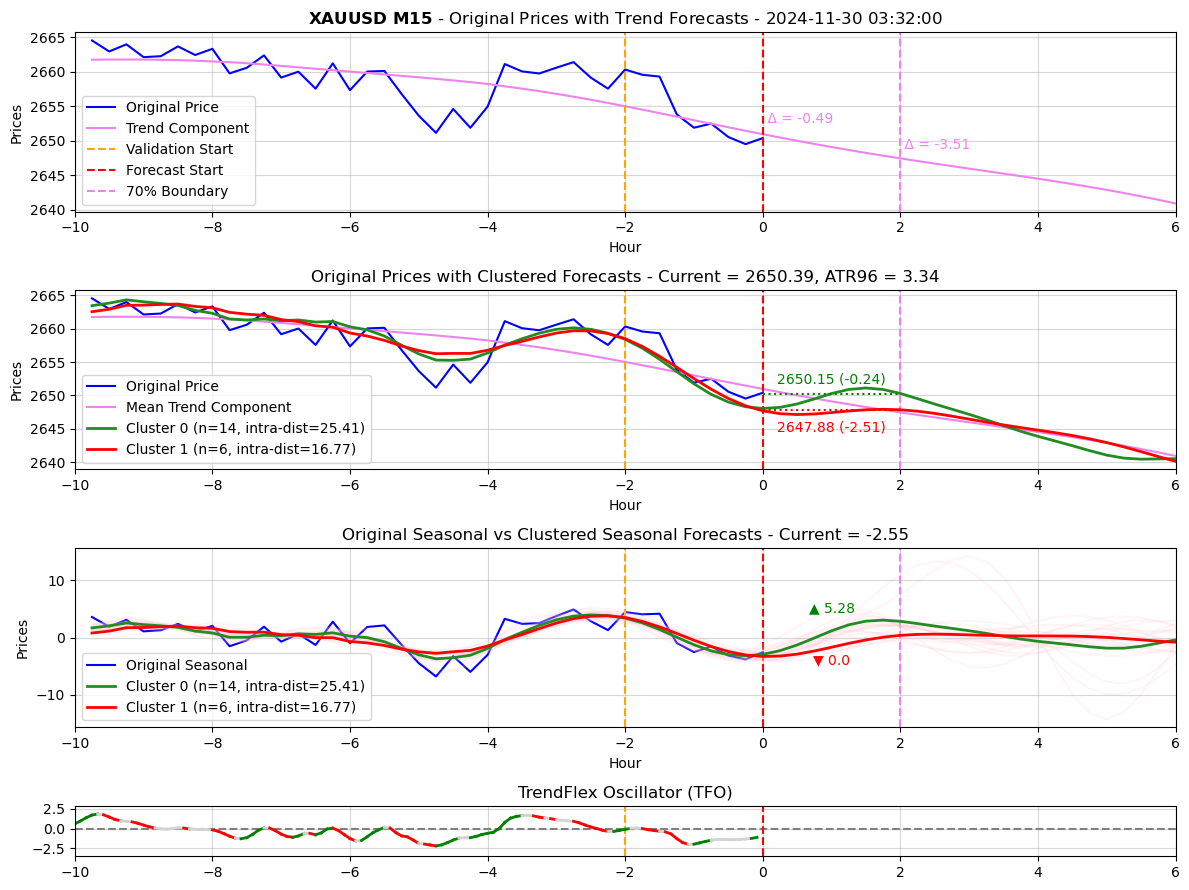

In [86]:
# Plotting
plt.figure(figsize=(12, 9))
colors = ['forestgreen', 'red', 'darkorange', 'dodgerblue']

# Plot 1: Original Price with Trend Forecasts
plt.subplot(7, 1, (1,2))
plt.plot(original_slice_idx_list*time_factor, prices_slice, label="Original Price", color='blue')
plt.plot(forecast_slice_idx_list*time_factor, t0_forecast_mean_slice, label='Trend Component', color='violet')
plt.axvline(x=-seasonal_validation_elements*time_factor, color='orange', linestyle='--', label="Validation Start")
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.axvline(x=seasonal_validation_elements*time_factor, color='violet', linestyle='--', label="70% Boundary")
# Additional information for trading strategy
transform = plt.gca().transData.inverted()
pixel_offset = transform.transform((0, 12)) - transform.transform((0, 0))
y_offset = pixel_offset[1] 
plt.text(0, t0_forecast_mean_slice[-visualization_elements_forecast-1] + y_offset * (1 if tstrend_short<0 else -1), f' Δ = {tstrend_short:.{target_precision}f}', color='violet', ha='left')
plt.text(seasonal_validation_elements*time_factor, t0_forecast_mean_slice[-visualization_elements_forecast+seasonal_validation_elements] + y_offset * (1 if tstrend_long<0 else -1), f' Δ = {tstrend_long:.{target_precision}f}', color='violet', ha='left')

plt.legend(loc = "lower left")
plt.title(rf"$\mathbf{{{target_symbol}\ {target_timeframe}}}$ - Original Prices with Trend Forecasts - {last_datetime}")
plt.xlabel(time_unit[target_timeframe])
plt.ylabel("Prices")
# Set x-axis limits
x_min = -math.ceil(visualization_elements_original*time_factor)
x_max = math.ceil(visualization_elements_forecast*time_factor)
plt.xlim(x_min, x_max)
x_ticks = np.arange(x_min - (x_min % grid_spacing), x_max + grid_spacing, grid_spacing)
plt.xticks(x_ticks)
plt.grid(True, alpha=0.5)



# Plot 2: Original Price with Clustered Forecasts
plt.subplot(7, 1, (3,4))
plt.plot(original_slice_idx_list*time_factor, prices_slice, label="Original Price", color='blue')
plt.plot(forecast_slice_idx_list*time_factor, t0_forecast_mean_slice, label='Mean Trend Component', color='violet')
plt.axvline(x=-seasonal_validation_elements*time_factor, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=seasonal_validation_elements*time_factor, color='violet', linestyle='--')
for label, indices in cluster_members.items():
    plt.plot(
        forecast_slice_idx_list*time_factor,
        t0_forecast_mean_slice+cluster_means_slice[label],
        color=colors[label],
        linewidth=2,
        label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
    )
# Additional information for trading strategy
transform = plt.gca().transData.inverted()
pixel_offset = transform.transform((0, 12)) - transform.transform((0, 0))
y_offset = pixel_offset[1]
plt.hlines(y=tsprice_max, xmin=0, xmax=seasonal_validation_elements*time_factor, color='green', linestyle=':')
plt.text(seasonal_validation_elements*time_factor/2, tsprice_max + y_offset, f'{tsprice_max} ({tsprice_potupper:+})', color='green', ha='center')
plt.hlines(y=tsprice_min, xmin=0, xmax=seasonal_validation_elements*time_factor, color='red', linestyle=':')
plt.text(seasonal_validation_elements*time_factor/2, tsprice_min - y_offset*2, f'{tsprice_min} ({tsprice_potlower:+})', color='red', ha='center')

plt.legend(loc = "lower left")
plt.title(f"Original Prices with Clustered Forecasts - Current = {tsprice_current}, ATR96 = {adjusted_atr}")
plt.xlabel(time_unit[target_timeframe])
plt.ylabel("Prices")
# Set x-axis limits
x_min = -math.ceil(visualization_elements_original*time_factor)
x_max = math.ceil(visualization_elements_forecast*time_factor)
plt.xlim(x_min, x_max)
x_ticks = np.arange(x_min - (x_min % grid_spacing), x_max + grid_spacing, grid_spacing)
plt.xticks(x_ticks)
plt.grid(True, alpha=0.5)


# Plot 3: Original Seasonal vs Clustered Seasonal Forecasts
plt.subplot(7, 1, (5,6))
plt.plot(original_slice_idx_list*time_factor, yvalues_seasonal_slice, label="Original Seasonal", color='blue')
plt.axvline(x=-seasonal_validation_elements*time_factor, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=seasonal_validation_elements*time_factor, color='violet', linestyle='--')
for row in s0_forecast_all_slice:
    plt.plot(forecast_slice_idx_list*time_factor, row, color='pink', alpha=0.15)
for label, indices in cluster_members.items():
    plt.plot(
        forecast_slice_idx_list*time_factor,
        cluster_means_slice[label],
        color=colors[label],
        linewidth=2,
        label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
    )
# Additional information for trading strategy
transform = plt.gca().transData.inverted()
pixel_offset = transform.transform((0, 20)) - transform.transform((0, 0))
y_offset = pixel_offset[1]
plt.text(seasonal_validation_elements*time_factor/2, tsseasonal_allmax + y_offset, f'▲ {tsseasonal_upside}', color='green', ha='center')
plt.text(seasonal_validation_elements*time_factor/2, tsseasonal_allmin - y_offset, f'▼ {tsseasonal_downside}', color='red', ha='center')

plt.legend(loc = "lower left")
plt.title(f"Original Seasonal vs Clustered Seasonal Forecasts - Current = {tsseasonal_current}")
plt.xlabel(time_unit[target_timeframe])
plt.ylabel("Prices")
# Set x-axis limits
x_min = -math.ceil(visualization_elements_original*time_factor)
x_max = math.ceil(visualization_elements_forecast*time_factor)
plt.xlim(x_min, x_max)
x_ticks = np.arange(x_min - (x_min % grid_spacing), x_max + grid_spacing, grid_spacing)
plt.xticks(x_ticks)
plt.grid(True, alpha=0.5)


# Plot 4: TFO
plt.subplot(7, 1, 7)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(x=-seasonal_validation_elements*time_factor, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
for i in range(1, len(tfo_values)):
    tfoidx = [(i-len(tfo_values)-1)*time_factor_tfo, (i-len(tfo_values))*time_factor_tfo]
    if tfo_slope.iloc[i] >= 0.1:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='green', linewidth=2)
    elif tfo_slope.iloc[i] <= -0.1:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='red', linewidth=2)
    else:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='lightgrey', linewidth=2)
plt.title('TrendFlex Oscillator (TFO)')
# Set x-axis limits
x_min = -math.ceil(visualization_elements_original*time_factor)
x_max = math.ceil(visualization_elements_forecast*time_factor)
plt.xlim(x_min, x_max)
x_ticks = np.arange(x_min - (x_min % grid_spacing), x_max + grid_spacing, grid_spacing)
plt.xticks(x_ticks)
plt.grid(True, alpha=0.5)

plt.tight_layout()

#plt.show()
plt.savefig('output1.png', bbox_inches='tight')
    

## 7 MT5 and Telegram

### 7.1 Mechanical

In [90]:
buy_condition = ( tfo_slope.iloc[-1] >= 0.1 and
                  tsseasonal_upside - tsseasonal_downside + tstrend_short > adjusted_atr )
sell_condition = ( tfo_slope.iloc[-1] <= -0.1 and
                   tsseasonal_downside - tsseasonal_upside - tstrend_short > adjusted_atr )


string1 = ""
buysell = ""
tp = 0.0
sl = 0.0
if sell_condition:
    buysell = "S"
    tp = tsprice_current-adjusted_atr
    sl = tsprice_current+adjusted_atr
    string1 = f'Sell - Price={tsprice_current}, TP:{tp}, SL:{sl}'
    print(string1)
elif buy_condition:
    buysell = "B"
    tp = tsprice_current+adjusted_atr
    sl = tsprice_current-adjusted_atr
    string1 = f'Buy - Price={tsprice_current}, TP:{tp}, SL:{sl}'
    print(string1)
else:
    string1 = ""
    buysell = ""
    print("No Action")

print("")



Buy - Price=2650.39, TP:2653.73, SL:2647.0499999999997



### 7.2 Machine Learning

In [117]:
string2 = ""
buysell2 = ""
tp2 = 0.0
sl2 = 0.0

if target_symbol == 'XAUUSD' and ML_Ready == True:
    buy_condition2 = pred_model['B']
    sell_condition2 = pred_model['S']

    if sell_condition2:
        buysell2 = "S"
        tp2 = tsprice_current-1.5*adjusted_atr
        sl2 = tsprice_current+adjusted_atr
        string2 = f'**ML** Sell - Price={tsprice_current}, TP:{tp2}, SL:{sl2}'
        print(string2)
    elif buy_condition2:
        buysell2 = "B"
        tp2 = tsprice_current+1.5*adjusted_atr
        sl2 = tsprice_current-adjusted_atr
        string2 = f'**ML** Buy - Price={tsprice_current}, TP:{tp2}, SL:{sl2}'
        print(string2)
    else:
        string2 = ""
        buysell2 = ""
        print("No Action for ML")

    print("")

In [ ]:
# If MetaTrader5 is not installed, uncomment the following line:
# !pip install MetaTrader5

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import pytz

def mt5_trading(login, password, server, target_symbol, buysell, tsprice_current, string_check, sl, tp, cooldown=False, path="", risk_percent=10, slbe_adjust=False):
    """
    Connects to MetaTrader 5, retrieves account information, checks positions and orders,
    and executes trading logic based on predefined conditions.

    Parameters:
    - login (int): Your MetaTrader 5 account login number.
    - password (str): Your MetaTrader 5 account password.
    - server (str): The server address for your MetaTrader 5 account.
    - target_symbol (str): The trading symbol (e.g., "GBPUSD").
    - buysell (str): Direction of the trade ("B" for Buy, "S" for Sell).
    - string1 (str): A string parameter used within the function.
    - tsprice_current (float): Current price of the symbol.
    - sl (float): Stop Loss value.
    - tp (float): Take Profit value.
    - cooldown (bool, optional): Initial cooldown status. Defaults to False.

    Returns:
    - mt5_string (str): A string summarizing the actions taken or any errors encountered.
    """
    
    timeout = 10000
    portable = True
    
    mt5_string = ""
    
    # Initialize MetaTrader 5 connection
    if not mt5.initialize(path=path, login=login, password=password, server=server, timeout=timeout, portable=portable):
        mt5_string = f"initialize() failed, error code = {mt5.last_error()}"
        print(mt5_string)
        return mt5_string
    else:
        print("Initialization successful")
    
    try:
        # Get account information
        account_info = mt5.account_info()
        if account_info is None:
            mt5_string = "Failed to retrieve account information."
            print(mt5_string)
            return mt5_string
        
        account_info_dict = account_info._asdict()
        account_info_df = pd.DataFrame(account_info_dict, index=[0])
    
        # Display relevant account information
        print("Profit:", account_info_df["profit"].iloc[0])
        print("Equity:", account_info_df["equity"].iloc[0])
        print("Margin:", account_info_df["margin"].iloc[0])
        print("Margin Free:", account_info_df["margin_free"].iloc[0])
        print("")
    
        # Retrieve positions and orders for the target symbol
        positions = mt5.positions_get(symbol=target_symbol)
        orders = mt5.orders_get(symbol=target_symbol)
    
        if not positions:
            print(f"No positions on {target_symbol}")
    
            if not orders:
                print(f"No orders on {target_symbol}")
    
                # Since string1 is ensured to be non-empty, proceed without checking
                # Define the time range for history deals
                to_date = datetime.now(tz=pytz.timezone("US/Eastern")) + timedelta(hours=7)
                from_date = to_date - timedelta(days=2)
                print(f"From Date: {from_date}")
                print(f"To Date: {to_date}")
    
                print("Epoch:", calendar.timegm(to_date.timetuple()))
    
                print("Hour:" + str(to_date.hour))
                if (to_date.hour == 23 or to_date.hour == 0):
                    cooldown = True
                    if string_check != "":
                        mt5_string = "23/00 hour cooldown"

                # Retrieve historical orders
                orders_hist = mt5.history_orders_get(from_date, to_date, group=target_symbol)
                               
                if not orders_hist:
                    print(f"No orders with group=\"{target_symbol}\", error code={mt5.last_error()}")
                else:
                    print(f"history_orders_get({from_date}, {to_date}, group=\"{target_symbol}\") = {len(orders_hist)}")
                    # Convert deals to DataFrame
                    df = pd.DataFrame([order._asdict() for order in orders_hist])
                    
                    print(df)

                    # Filter deals: Cancel only
                    filtered_df = df[df['state'] ==mt5.ORDER_STATE_CANCELED]
                    if not filtered_df.empty:
                        last_order = filtered_df.iloc[-1]
                        print(last_order)
                        # Check 30-minute TP cooldown
                        minus30min = calendar.timegm(to_date.timetuple()) - (30 * 60)
                        print("Epoch-30m:", minus30min)
    
                        # Last trade TP within 30 minutes
                        if (last_order['time_done'] > minus30min):
                            cooldown = True
                            if string_check != "":
                                mt5_string = "30min Cancel cooldown"

                # Retrieve historical deals
                deals = mt5.history_deals_get(from_date, to_date, group=target_symbol)
                
                if not deals:
                    print(f"No deals with group=\"{target_symbol}\", error code={mt5.last_error()}")
                else:
                    print(f"history_deals_get({from_date}, {to_date}, group=\"{target_symbol}\") = {len(deals)}")
                    # Convert deals to DataFrame
                    df = pd.DataFrame([deal._asdict() for deal in deals])
                    df['time'] = pd.to_datetime(df['time'], unit='s')
                    print(df)
    
                    # Filter deals: Buy/Sell market/limitonly
                    filtered_df = df[df['type'] <=3]
                    # Filter deals: Close position only (assuming 'entry' field indicates this)
                    if 'entry' in filtered_df.columns:
                        filtered_df2 = filtered_df[filtered_df['entry'] == 1]
                    else:
                        # If 'entry' field does not exist, skip this filter
                        filtered_df2 = filtered_df
                    # Extract last 2 rows
                    filtered_df3 = filtered_df2.tail(4)
                    print(filtered_df3)
    
                    if not filtered_df3.empty:
                        last_deal = filtered_df3.iloc[-1]
                        print(last_deal)
    
                        # Check 30-minute TP cooldown
                        minus30min = calendar.timegm(to_date.timetuple()) - (30 * 60)
                        print("Epoch-30m:", minus30min)
    
                        # Last trade TP within 30 minutes and same side
                        if (last_deal['profit'] > 0) and (last_deal['time'].timestamp() > minus30min):
                            if buysell.upper() == "B" and (last_deal['type'] == mt5.ORDER_TYPE_SELL or last_deal['type'] == mt5.ORDER_TYPE_SELL_LIMIT):
                                cooldown = True
                                if string_check != "":
                                    mt5_string = "Buy Side, 30min TP cooldown"
                            elif buysell.upper() == "S" and (last_deal['type'] == mt5.ORDER_TYPE_BUY or last_deal['type'] == mt5.ORDER_TYPE_BUY_LIMIT):
                                cooldown = True
                                if string_check != "":
                                    mt5_string = "Sell Side, 30min TP cooldown"
    
                        # Check 2-hour double SL cooldown
                        minus2hr = calendar.timegm(to_date.timetuple()) - (120 * 60)
                        print("Epoch-2hr:", minus2hr)
    
                        if slbe_adjust:
                            if len(filtered_df3) >= 4:
                                second_last_deal = filtered_df3.iloc[-3]
                                if (last_deal['profit'] < 0 and last_deal['time'].timestamp() > minus2hr and
                                    second_last_deal['profit'] < 0 and second_last_deal['time'].timestamp() > minus2hr):
                                    
                                    if buysell.upper() == "B" and (last_deal['type'] == mt5.ORDER_TYPE_SELL or last_deal['type'] == mt5.ORDER_TYPE_SELL_LIMIT) and (second_last_deal['type'] == mt5.ORDER_TYPE_SELL or second_last_deal['type'] == mt5.ORDER_TYPE_SELL_LIMIT):
                                        cooldown = True
                                        if string_check != "":
                                            mt5_string = "Buy Side, 120min double SL cooldown"
                                    elif buysell.upper() == "S" and (last_deal['type'] == mt5.ORDER_TYPE_BUY or last_deal['type'] == mt5.ORDER_TYPE_BUY_LIMIT) and (second_last_deal['type'] == mt5.ORDER_TYPE_BUY or second_last_deal['type'] == mt5.ORDER_TYPE_BUY_LIMIT):
                                        cooldown = True
                                        if string_check != "":
                                            mt5_string = "Sell Side, 120min double SL cooldown"
                        else:
                            if len(filtered_df3) >= 2:
                                second_last_deal = filtered_df3.iloc[-2]
                                if (last_deal['profit'] < 0 and last_deal['time'].timestamp() > minus2hr and
                                    second_last_deal['profit'] < 0 and second_last_deal['time'].timestamp() > minus2hr):
                                    
                                    if buysell.upper() == "B" and (last_deal['type'] == mt5.ORDER_TYPE_SELL or last_deal['type'] == mt5.ORDER_TYPE_SELL_LIMIT) and (second_last_deal['type'] == mt5.ORDER_TYPE_SELL or second_last_deal['type'] == mt5.ORDER_TYPE_SELL_LIMIT):
                                        cooldown = True
                                        if string_check != "":
                                            mt5_string = "Buy Side, 120min double SL cooldown"
                                    elif buysell.upper() == "S" and (last_deal['type'] == mt5.ORDER_TYPE_BUY or last_deal['type'] == mt5.ORDER_TYPE_BUY_LIMIT) and (second_last_deal['type'] == mt5.ORDER_TYPE_BUY or second_last_deal['type'] == mt5.ORDER_TYPE_BUY_LIMIT):
                                        cooldown = True
                                        if string_check != "":
                                            mt5_string = "Sell Side, 120min double SL cooldown"
    
                print()
    
                if not cooldown and string_check != "":
                    print("Start sending order")
                    # Prepare the buy/sell request structure
                    symbol_info = mt5.symbol_info(target_symbol)
                    if symbol_info is None:
                        mt5_string = f"{target_symbol} not found, cannot call order_check()"
                        print(mt5_string)
                        mt5.shutdown()
                        return mt5_string
                    
                    # If the symbol is unavailable in MarketWatch, add it
                    if not symbol_info.visible:
                        print(f"{target_symbol} is not visible, trying to switch on")
                        if not mt5.symbol_select(target_symbol, True):
                            mt5_string = f"symbol_select({target_symbol}) failed, exit"
                            print(mt5_string)
                            mt5.shutdown()
                            return mt5_string
                    
                    # Calculate lot size based on risk
                    lot = 0.01
                    
                    risk_amount = account_info_df["equity"].iloc[0] * risk_percent / 100
    
                    if target_symbol.upper() == "XAUUSD":
                        # Example calculation; replace tsprice_current and sl with actual values
                        if abs(tsprice_current - sl) != 0:
                            lot = round(risk_amount / abs(tsprice_current - sl) * 0.01, 2)
                            if slbe_adjust:
                                lot = round(lot/2,2)
                        else:
                            lot = 0.01
                    elif target_symbol.upper() == "USDJPY" or target_symbol.upper() == "USDCHF":
                        if tsprice_current != 0:
                            lot = round(risk_amount / (abs((tsprice_current - sl) / tsprice_current) * 100000), 2)
                            if slbe_adjust:
                                lot = round(lot/2,2)
                        else:
                            lot = 0.01
                    elif target_symbol.upper() == "BTCUSD":
                        if abs(tsprice_current - sl) != 0:
                            lot = round(risk_amount / abs(tsprice_current - sl), 2)
                            if slbe_adjust:
                                lot = round(lot/2,2)
                        else:
                            lot = 0.01
                    elif target_symbol.upper() == "EURUSD":
                        if abs(tsprice_current - sl) != 0:
                            lot = round(risk_amount / (abs(tsprice_current - sl)*100000), 2)
                            if slbe_adjust:
                                lot = round(lot/2,2)
                        else:
                            lot = 0.01
                    elif  target_symbol.upper() == "EURGBP":
                        ref_symbol_info = mt5.symbol_info("GBPUSD")
                        if ref_symbol_info is None:
                            mt5_string = f"{"GBPUSD"} not found, cannot call order_check()"
                            print(mt5_string)
                            mt5.shutdown()
                            return mt5_string
                        
                        # If the symbol is unavailable in MarketWatch, add it
                        if not ref_symbol_info.visible:
                            print(f"{"GBPUSD"} is not visible, trying to switch on")
                            if not mt5.symbol_select("GBPUSD", True):
                                mt5_string = f"symbol_select({"GBPUSD"}) failed, exit"
                                print(mt5_string)
                                mt5.shutdown()
                                return mt5_string

                        print("Ready to get ref_symbol_info")
                        lasttick=mt5.symbol_info_tick("GBPUSD")
                        print(lasttick)

                        if abs(tsprice_current - sl) != 0:
                            lot = round(risk_amount / (abs(tsprice_current - sl)*100000 * lasttick.bid), 2)
                            if slbe_adjust:
                                lot = round(lot/2,2)
                        else:
                            lot = 0.01

                    if lot <= 0.01:
                        lot = 0.01
    
                    print(f"Risk %: {risk_percent} Risk amount: {risk_amount}")
                    print(f"Price: {tsprice_current} SL: {sl}")
                    print(f"Lot size: {lot}")
    
                    # Define order parameters
                    price = tsprice_current
                    deviation = 20
                    if buysell.upper() == "B":
                        if mt5.symbol_info_tick(target_symbol).ask > price:
                            print("Send Pending order")
                            request = {
                                "action": mt5.TRADE_ACTION_PENDING,
                                "symbol": target_symbol,
                                "volume": lot,
                                "type": mt5.ORDER_TYPE_BUY_LIMIT,
                                "price": price,
                                "sl": sl,
                                "tp": tp,
                                "deviation": 5,
                                "magic": 88888,
                                "comment": "python map limit",
                                "type_time": mt5.ORDER_TIME_GTC,
                                "type_filling": mt5.ORDER_FILLING_RETURN,
                            }
                        else:
                            print("Send Market order")
                            request = {
                                "action": mt5.TRADE_ACTION_DEAL,
                                "symbol": target_symbol,
                                "volume": lot,
                                "type": mt5.ORDER_TYPE_BUY,
                                "price": price,
                                "sl": sl,
                                "tp": tp,
                                "deviation": deviation,
                                "magic": 88888,
                                "comment": "python map",
                                "type_time": mt5.ORDER_TIME_GTC,
                                "type_filling": mt5.ORDER_FILLING_IOC,
                            }
                    else:
                        if mt5.symbol_info_tick(target_symbol).bid < price:
                            print("Send Pending order")
                            request = {
                                "action": mt5.TRADE_ACTION_PENDING,
                                "symbol": target_symbol,
                                "volume": lot,
                                "type": mt5.ORDER_TYPE_SELL_LIMIT,
                                "price": price,
                                "sl": sl,
                                "tp": tp,
                                "deviation": 5,
                                "magic": 88888,
                                "comment": "python map limit",
                                "type_time": mt5.ORDER_TIME_GTC,
                                "type_filling": mt5.ORDER_FILLING_RETURN,
                            }
                        else:
                            print("Send Market order")
                            request = {
                                "action": mt5.TRADE_ACTION_DEAL,
                                "symbol": target_symbol,
                                "volume": lot,
                                "type": mt5.ORDER_TYPE_SELL,
                                "price": price,
                                "sl": sl,
                                "tp": tp,
                                "deviation": deviation,
                                "magic": 88888,
                                "comment": "python map",
                                "type_time": mt5.ORDER_TIME_GTC,
                                "type_filling": mt5.ORDER_FILLING_IOC,
                            }

                    if slbe_adjust:
                        if buysell.upper() == "B":
                            if mt5.symbol_info_tick(target_symbol).ask > price:
                                print("Send Pending order")
                                request2 = {
                                    "action": mt5.TRADE_ACTION_PENDING,
                                    "symbol": target_symbol,
                                    "volume": lot,
                                    "type": mt5.ORDER_TYPE_BUY_LIMIT,
                                    "price": price,
                                    "sl": sl,
                                    "tp": (tp+price)/2,
                                    "deviation": 5,
                                    "magic": 88888,
                                    "comment": "python map limit",
                                    "type_time": mt5.ORDER_TIME_GTC,
                                    "type_filling": mt5.ORDER_FILLING_RETURN,
                                }
                            else:
                                print("Send Market order")
                                request2 = {
                                    "action": mt5.TRADE_ACTION_DEAL,
                                    "symbol": target_symbol,
                                    "volume": lot,
                                    "type": mt5.ORDER_TYPE_BUY,
                                    "price": price,
                                    "sl": sl,
                                    "tp": (tp+price)/2,
                                    "deviation": deviation,
                                    "magic": 88888,
                                    "comment": "python map",
                                    "type_time": mt5.ORDER_TIME_GTC,
                                    "type_filling": mt5.ORDER_FILLING_IOC,
                                }
                        else:
                            if mt5.symbol_info_tick(target_symbol).bid < price:
                                print("Send Pending order")
                                request2 = {
                                    "action": mt5.TRADE_ACTION_PENDING,
                                    "symbol": target_symbol,
                                    "volume": lot,
                                    "type": mt5.ORDER_TYPE_SELL_LIMIT,
                                    "price": price,
                                    "sl": sl,
                                    "tp": (tp+price)/2,
                                    "deviation": 5,
                                    "magic": 88888,
                                    "comment": "python map limit",
                                    "type_time": mt5.ORDER_TIME_GTC,
                                    "type_filling": mt5.ORDER_FILLING_RETURN,
                                }
                            else:
                                print("Send Market order")
                                request2 = {
                                    "action": mt5.TRADE_ACTION_DEAL,
                                    "symbol": target_symbol,
                                    "volume": lot,
                                    "type": mt5.ORDER_TYPE_SELL,
                                    "price": price,
                                    "sl": sl,
                                    "tp": (tp+price)/2,
                                    "deviation": deviation,
                                    "magic": 88888,
                                    "comment": "python map",
                                    "type_time": mt5.ORDER_TIME_GTC,
                                    "type_filling": mt5.ORDER_FILLING_IOC,
                                }

                    # Send a trading request
                    result = mt5.order_send(request)
                    mt5_string = (f"Sending order {target_symbol} Lot: {lot} "
                                  f"Price: {price} Dev: {deviation} TP: {tp} SL: {sl}")
    
                    # Check the execution result
                    print("Last error code =", mt5.last_error())
                    print(f"1. order_send(): by {target_symbol} {lot} lots at {price} with deviation={deviation} points")
                    if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                        mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                        print(f"2. order_send failed, retcode={result.retcode}")
                        # Display result details
                        result_dict = result._asdict()
                        for field in result_dict:
                            print(f"   {field}={result_dict[field]}")
                            if field == "request":
                                traderequest_dict = result_dict[field]._asdict()
                                for tradereq_field in traderequest_dict:
                                    print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
                    
                    if slbe_adjust:
                        # Send a trading request
                        result = mt5.order_send(request2)
        
                        # Check the execution result
                        print("Last error code =", mt5.last_error())
                        print(f"1. order_send(): by {target_symbol} {lot} lots at {price} with deviation={deviation} points")
                        if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                            mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                            print(f"2. order_send failed, retcode={result.retcode}")
                            # Display result details
                            result_dict = result._asdict()
                            for field in result_dict:
                                print(f"   {field}={result_dict[field]}")
                                if field == "request":
                                    traderequest_dict = result_dict[field]._asdict()
                                    for tradereq_field in traderequest_dict:
                                        print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
    
            else:
                print(f"Total orders: {len(orders)}")
                #mt5_string = f"Total orders: {len(orders)}, Skip"
                # Display all active orders
                for order in orders:
                    print(order)

                now_date = datetime.now(tz=pytz.timezone("US/Eastern")) + timedelta(hours=7)
                minus30min = calendar.timegm(now_date.timetuple()) - (30 * 60)
                print("Epoch:", calendar.timegm(now_date.timetuple()))
                print("Epoch-30m:", minus30min)
                print("Order Epoch:", orders[0].time_setup)

                for order in orders:
                    if (order.type == mt5.ORDER_TYPE_BUY_LIMIT and order.price_current > order.tp) or (order.type == mt5.ORDER_TYPE_SELL_LIMIT and  order.price_current < order.tp):
                        print("Already TP price, Close order")

                        request = {
                            "action": mt5.TRADE_ACTION_REMOVE,
                            "order": order.ticket,
                            "symbol": order.symbol,
                            "volume": order.volume_current,
                            "magic": 88888
                        }
                        # Send a trading request to close the position
                        mt5_string = f"Already TP, Remove pending: {order.symbol}"
                        result = mt5.order_send(request)
                        if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                            mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                            print(f"2. order_send failed, retcode={result.retcode}")
                            # Display result details
                            result_dict = result._asdict()
                            for field in result_dict:
                                print(f"   {field}={result_dict[field]}")
                                if field == "request":
                                    traderequest_dict = result_dict[field]._asdict()
                                    for tradereq_field in traderequest_dict:
                                        print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
            
                    elif order.time_setup < minus30min:
                        print("More than 30 Min, Close pending order now")

                        request = {
                            "action": mt5.TRADE_ACTION_REMOVE,
                            "order": order.ticket,
                            "symbol": order.symbol,
                            "volume": order.volume_current,
                            "magic": 88888
                        }
                        # Send a trading request to close the position
                        mt5_string = f"More than 30 min, Remove pending: {order.symbol}"
                        result = mt5.order_send(request)
                        if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                            mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                            print(f"2. order_send failed, retcode={result.retcode}")
                            # Display result details
                            result_dict = result._asdict()
                            for field in result_dict:
                                print(f"   {field}={result_dict[field]}")
                                if field == "request":
                                    traderequest_dict = result_dict[field]._asdict()
                                    for tradereq_field in traderequest_dict:
                                        print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
        
        else:
            print(f"Total positions: {len(positions)}")
            #mt5_string = f"Total positions: {len(positions)}, Skip"
            # Display all active positions
            for position in positions:
                print(position)
    
            now_date = datetime.now(tz=pytz.timezone("US/Eastern")) + timedelta(hours=7)
            minus60min = calendar.timegm(now_date.timetuple()) - (60 * 60)
            minus120min = calendar.timegm(now_date.timetuple()) - (120 * 60)
            print("Epoch:", calendar.timegm(now_date.timetuple()))
            print("Epoch-60m:", minus60min)
            print("Epoch-120m:", minus120min)
            print("Order Epoch:", positions[0].time)
    
            for position in positions:
                if position.time < minus120min:
                    print("More than 120 Min, Close now")
                    if position.type == mt5.ORDER_TYPE_BUY or position.type == mt5.ORDER_TYPE_BUY_LIMIT:
                        request = {
                            "action": mt5.TRADE_ACTION_DEAL,
                            "position": position.ticket,
                            "symbol": position.symbol,
                            "volume": position.volume,
                            "price": mt5.symbol_info_tick(position.symbol).bid,
                            "deviation": 20,
                            "magic": 88888,
                            "type_filling": mt5.ORDER_FILLING_IOC,
                            "type": mt5.ORDER_TYPE_SELL
                        }
                    elif position.type == mt5.ORDER_TYPE_SELL or position.type == mt5.ORDER_TYPE_SELL_LIMIT:
                        request = {
                            "action": mt5.TRADE_ACTION_DEAL,
                            "position": position.ticket,
                            "symbol": position.symbol,
                            "volume": position.volume,
                            "price": mt5.symbol_info_tick(position.symbol).ask,
                            "deviation": 20,
                            "magic": 88888,
                            "type_filling": mt5.ORDER_FILLING_IOC,
                            "type": mt5.ORDER_TYPE_BUY
                        }
                    # Send a trading request to close the position
                    mt5_string = f"Closing: {position.symbol}"
                    result = mt5.order_send(request)
                    if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                        mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                        print(f"2. order_send failed, retcode={result.retcode}")
                        # Display result details
                        result_dict = result._asdict()
                        for field in result_dict:
                            print(f"   {field}={result_dict[field]}")
                            if field == "request":
                                traderequest_dict = result_dict[field]._asdict()
                                for tradereq_field in traderequest_dict:
                                    print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
        
                elif position.time < minus60min and position.price_open != position.tp:
                    print("More than 60 Min, Change to BE")

                    if ((position.type == mt5.ORDER_TYPE_BUY or position.type == mt5.ORDER_TYPE_BUY_LIMIT) and mt5.symbol_info_tick(position.symbol).bid > position.price_open) or ((position.type == mt5.ORDER_TYPE_SELL or position.type == mt5.ORDER_TYPE_SELL_LIMIT) and mt5.symbol_info_tick(position.symbol).ask < position.price_open):
                        print("Have profit, Close now")
                        if position.type == mt5.ORDER_TYPE_BUY or position.type == mt5.ORDER_TYPE_BUY_LIMIT:
                            request = {
                                "action": mt5.TRADE_ACTION_DEAL,
                                "position": position.ticket,
                                "symbol": position.symbol,
                                "volume": position.volume,
                                "price": mt5.symbol_info_tick(position.symbol).bid,
                                "deviation": 20,
                                "magic": 88888,
                                "type_filling": mt5.ORDER_FILLING_IOC,
                                "type": mt5.ORDER_TYPE_SELL
                            }
                        elif position.type == mt5.ORDER_TYPE_SELL or position.type == mt5.ORDER_TYPE_SELL_LIMIT:
                            request = {
                                "action": mt5.TRADE_ACTION_DEAL,
                                "position": position.ticket,
                                "symbol": position.symbol,
                                "volume": position.volume,
                                "price": mt5.symbol_info_tick(position.symbol).ask,
                                "deviation": 20,
                                "magic": 88888,
                                "type_filling": mt5.ORDER_FILLING_IOC,
                                "type": mt5.ORDER_TYPE_BUY
                            }

                        # Send a trading request to close the position
                        mt5_string = f"BE Closing: {position.symbol}"
                        result = mt5.order_send(request)
                        if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                            mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                            print(f"2. order_send failed, retcode={result.retcode}")
                            # Display result details
                            result_dict = result._asdict()
                            for field in result_dict:
                                print(f"   {field}={result_dict[field]}")
                                if field == "request":
                                    traderequest_dict = result_dict[field]._asdict()
                                    for tradereq_field in traderequest_dict:
                                        print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
                    else:
                        print("No profit, BE now")
                        request = {
                            "action": mt5.TRADE_ACTION_SLTP,
                            "position": position.ticket,
                            "symbol": position.symbol,
                            "magic": position.magic,
                            "tp": position.price_open,  # Update as needed
                            "sl": position.sl   # Update as needed
                        }
                        mt5_string = f"Sending BE: {position.symbol}"
                        result = mt5.order_send(request)
                        if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                            mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                            print(f"2. order_send failed, retcode={result.retcode}")
                            # Display result details
                            result_dict = result._asdict()
                            for field in result_dict:
                                print(f"   {field}={result_dict[field]}")
                                if field == "request":
                                    traderequest_dict = result_dict[field]._asdict()
                                    for tradereq_field in traderequest_dict:
                                        print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")
                
                if slbe_adjust == True and position.price_open != position.sl:
                    print("Need to do SL->BE")
                    if (len(positions) ==1) and (((position.type == mt5.ORDER_TYPE_BUY or position.type == mt5.ORDER_TYPE_BUY_LIMIT) and mt5.symbol_info_tick(position.symbol).bid > position.price_open) or ((position.type == mt5.ORDER_TYPE_SELL or position.type == mt5.ORDER_TYPE_SELL_LIMIT) and mt5.symbol_info_tick(position.symbol).ask < position.price_open)):
                        print("Criteria hit, start working")
                        request = {
                            "action": mt5.TRADE_ACTION_SLTP,
                            "position": position.ticket,
                            "symbol": position.symbol,
                            "magic": position.magic,
                            "tp": position.tp,  # Update as needed
                            "sl": position.price_open   # Update as needed
                        }
                        mt5_string = f"Sending SL to BE: {position.symbol}"
                        result = mt5.order_send(request)
                        if result is not None and result.retcode != mt5.TRADE_RETCODE_DONE:
                            mt5_string = f"Order send failed= {result.retcode} {result.comment}"
                            print(f"2. order_send failed, retcode={result.retcode}")
                            # Display result details
                            result_dict = result._asdict()
                            for field in result_dict:
                                print(f"   {field}={result_dict[field]}")
                                if field == "request":
                                    traderequest_dict = result_dict[field]._asdict()
                                    for tradereq_field in traderequest_dict:
                                        print(f"       traderequest: {tradereq_field}={traderequest_dict[tradereq_field]}")

        print()
    
    finally:
        # Shut down connection to MetaTrader 5
        mt5.shutdown()
        print("Connection to MetaTrader 5 closed.")
    
    print("mt5_string:", mt5_string)
    return mt5_string


if send_order :
    user_login = 123123123
    user_password = "ABCD1234"
    user_server = "ICMarketsSC-Demo"
    result1 = mt5_trading(
        login=user_login,
        password=user_password,
        server=user_server,
        target_symbol=target_symbol,
        buysell=buysell,
        tsprice_current=tsprice_current,
        string_check=string1,
        sl=sl,
        tp=tp,
        cooldown=False,
        path = "F:\\MetaTrader 5\\terminal64.exe",
        risk_percent = 10,
        slbe_adjust=False
    )
    print("Result:", result1)





ModuleNotFoundError: No module named 'MetaTrader5'

In [ ]:
import telegram
import asyncio

async def run_bot(caption=""):
    if send_order :
        TELEGRAM_MESSAGE_THREAD = ''
    else:
        TELEGRAM_MESSAGE_THREAD = ''

    TELEGRAM_BOT_TOKEN = ''
    TELEGRAM_CHAT_ID = ''
    PHOTO_PATH = 'output1.png'
    bot = telegram.Bot(token=TELEGRAM_BOT_TOKEN)

    try:
        await bot.send_photo(photo=open(PHOTO_PATH, 'rb'), message_thread_id=TELEGRAM_MESSAGE_THREAD ,chat_id=TELEGRAM_CHAT_ID, caption=caption)
    except Exception:
        pass
        print("Timeout was received")
    finally:
        print("Telegram message send")

#await run_bot()
if send_order:
    if string1 != "" or result1 != "":
        caption_to_send = f"{string1}\n{result1}\n{string2}".strip()
        asyncio.run(run_bot(caption=caption_to_send))
else:
    caption_to_send = f"{string1}\n{string2}".strip()
    asyncio.run(run_bot(caption=caption_to_send))